<a href="https://colab.research.google.com/github/robgon-art/portraits-from-the-multiverse/blob/main/Portraits_from_the_Multiverse_StyleCLIP_Image_Modification_with_InterFaceGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Portraits from the Multiverse - Image Modification with InterFaceGAN**
## Using Machine Learning to change the gender, ethnicity, and age of peoples faces

By Robert. A Gonsalves</br>

## Acknowledgements
* StyleCLIP by O. Patashnik, Z. Wu, E., D. Cohen-Or, and D. Lischinski, [StyleCLIP: Text-Driven Manipulation of StyleGAN Imagery](https://arxiv.org/pdf/2103.17249.pdf)</br>
* CLIP by A. Radford, et al., [Learning Transferable Visual Models From Natural Language Supervision](https://medium.com/r/?url=https%3A%2F%2Fcdn.openai.com%2Fpapers%2FLearning_Transferable_Visual_Models_From_Natural_Language_Supervision.pdf)</br>
* StyleGAN 2 by T. Karras, S. Laine, M. Aittala, J. Hellsten, J. Lehtinen, and T. Aila, [Analyzing and Improving the Image Quality of StyleGAN](https://arxiv.org/pdf/1912.04958.pdf)</br>
* StyleGAN 2 implementation by rosinality, https://github.com/rosinality/stylegan2-pytorch</br></br>

![sample images](https://raw.githubusercontent.com/robgon-art/portraits-from-the-multiverse/main/cover_shot_med.jpg)

You can see my article on Medium.

In [ ]:
#@title Setup (may take a few minutes)
import os
os.chdir('/content')
CODE_DIR = 'encoder4editing'

!git clone https://github.com/omertov/encoder4editing.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.

%load_ext autoreload
%autoreload 2

experiment_type = 'ffhq_encode'
!mkdir /content/encoder4editing/pretrained_models
!gdown --id 1-7kW_9MyDGRFJff0Uzl2J13CNK3AoI-I -O /content/encoder4editing/pretrained_models/e4e_ffhq_encode.pt
!gdown --id 11DUJLFSNO_b3Q93ll81HEJC5_sxMTHGr -O /content/janis.png

In [5]:
#@title Specify the Image

image_path = "/content/janis.png" #@param {type: "string"}

EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/e4e_ffhq_encode.pt",
        "image_path": image_path
    },
    "cars_encode": {
        "model_path": "pretrained_models/e4e_cars_encode.pt",
        "image_path": "notebooks/images/car_img.jpg"
    },
    "horse_encode": {
        "model_path": "pretrained_models/e4e_horse_encode.pt",
        "image_path": "notebooks/images/horse_img.jpg"
    },
    "church_encode": {
        "model_path": "pretrained_models/e4e_church_encode.pt",
        "image_path": "notebooks/images/church_img.jpg"
    }
    
}
# Setup required image transformations
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]
if experiment_type == 'cars_encode':
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
            transforms.Resize((192, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 192)
else:
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
        transforms.Resize((256, 256)), #(256, 256)
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 256)

model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading e4e over the pSp framework from checkpoint: pretrained_models/e4e_ffhq_encode.pt
Model successfully loaded!


--2022-02-03 00:40:24--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  2.24MB/s    in 33s     

2022-02-03 00:40:57 (1.85 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Aligned image has shape: (256, 256)


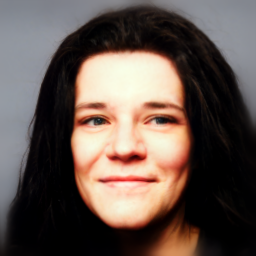

In [6]:
#@title Align the Image

image_path = EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")

if experiment_type == "ffhq_encode" and 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
  !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
  !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if experiment_type == "ffhq_encode":
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

(256, 256)
Inference took 0.0746 seconds.


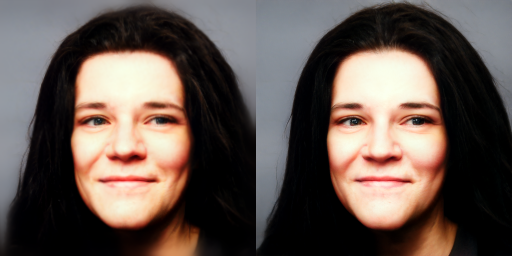

In [10]:
#@title Invert the Image

img_transforms = EXPERIMENT_ARGS['transform']
print(input_image.size)
transformed_image = img_transforms(input_image)

def display_alongside_source_image(result_image, source_image):
  res = np.concatenate([np.array(source_image.resize(resize_dims)),
                        np.array(result_image.resize(resize_dims))], axis=1)
  return Image.fromarray(res)

def run_on_batch(inputs, net):
  images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
  if experiment_type == 'cars_encode':
    images = images[:, :, 32:224, :]
  return images, latents

with torch.no_grad():
  tic = time.time()
  images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
  result_image, latent = images[0], latents[0]
  toc = time.time()
  print('Inference took {:.4f} seconds.'.format(toc - tic))

from editings import latent_editor
is_cars = experiment_type == 'cars_encode'
editor = latent_editor.LatentEditor(net.decoder, is_cars)

# InterFaceGAN
interfacegan_directions = {
  'ffhq_encode': {
    'age': 'editings/interfacegan_directions/age.pt',
    'smile': 'editings/interfacegan_directions/smile.pt',
    'pose': 'editings/interfacegan_directions/pose.pt'
  }
}
available_interfacegan_directions = None
if experiment_type in interfacegan_directions:  # List supported directions for the current experiment
  available_interfacegan_directions = interfacegan_directions[experiment_type]
  # print(list(available_interfacegan_directions.keys()))
# Display inversion:
display_alongside_source_image(tensor2im(result_image), input_image)

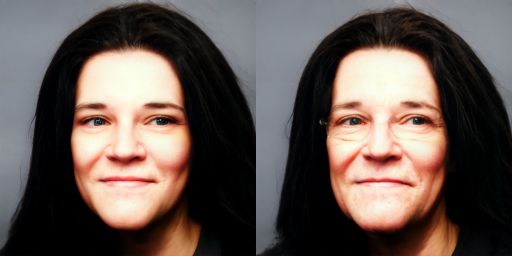

In [20]:
#@title Modify the Image

direction = 'age' #@param ["age", "smile", "pose"]
factor = 2 #@param {type:"slider", min:-4, max:4, step:0.1}

# As an example, we currently released the age and smile directions for the FFHQ StyleGAN Generator.
interfacegan_direction = torch.load(available_interfacegan_directions[direction]).cuda()

# For a single edit:
result = editor.apply_interfacegan(latents, interfacegan_direction, factor=factor).resize(resize_dims)
display_alongside_source_image(result, tensor2im(result_image))